# Annotated Graph Transformer

## Prelim

In [1]:
import torch
import dgl
from torch import nn
import torch.nn.functional as F
from dgl import function as fn
import numpy as np
import seaborn as sns
from matplotlib import pylab as plt
from dgl import ops as Fops

Using backend: pytorch


## Background

### Feed-Forward Networks with DGL

## Standard Mult-Head Attention using Torch

In [2]:
# say we have our three linear embeddings of query, key, and value
# it is assumed the dimensions between key and value are equivalent
q = torch.randn(10, 4, 30)
k = torch.randn(10, 3, 30)
v = torch.randn(10, 3, 30)

# Attention is generally applied with QK^TV, often with scaling and softmax applied,
# as in softmax(scaling * QK^T)V
print(torch.matmul(torch.matmul(q, k.transpose(-2, -1)), v).shape)


# to do multihead attention, we split the tensor across multiple heads
# we first calculate some dimensions
batch_size = q.size(0)
d_model = q.size(-1)
heads = 5
d_k = d_model // heads

# else we need to change our embeddings a bit
assert d_model % heads == 0

# then we split d_model across multiple heads
q_view = q.view(batch_size, -1, heads, d_k)

# we then swap the head to the non-matrix (i.e. batch) dimensions using transpose
q_view = q_view.transpose(1, 2)

# NOTE: it must be done in this was as not to juggle the values

# resulting in (batch_size, h, i, d_k)
# our aim is to sum across d_k during matrix multiplication, so that (b, h, i, d_k) * (b, h, d_k, j) -> (b, h, i, j)
# final matmul with the value results in (b, h, i, j) * (b, h, j, d_k) -> (b, h, j, d_k)
q_view = q.view(batch_size, -1, heads, d_k).transpose(1, 2)
k_view = k.view(batch_size, -1, heads, d_k).transpose(1, 2)
v_view = v.view(batch_size, -1, heads, d_k).transpose(1, 2)
    
z = torch.matmul(q_view, k_view.transpose(-2, -1))
print(z.shape)

# the attention as a specific head (e.g. batch=0, head=1) can be found using:
print(z[0, 1])

# out final values with attenion applied
a = torch.matmul(z, v_view)

# which returns us to the original shape
a.view(batch_size, -1, heads * d_k).shape

torch.Size([10, 4, 30])
torch.Size([10, 5, 4, 3])
tensor([[-0.8358, -2.2271,  0.7460],
        [-2.0253,  3.6990,  3.5973],
        [ 4.6658, -2.2204, -2.0328],
        [-0.9512,  2.4042,  0.8838]])


torch.Size([10, 4, 30])

Graph(num_nodes=5, num_edges=4,
      ndata_schemes={'k': Scheme(shape=(12,), dtype=torch.float32), 'q': Scheme(shape=(12,), dtype=torch.float32), 'v': Scheme(shape=(12,), dtype=torch.float32)}
      edata_schemes={})


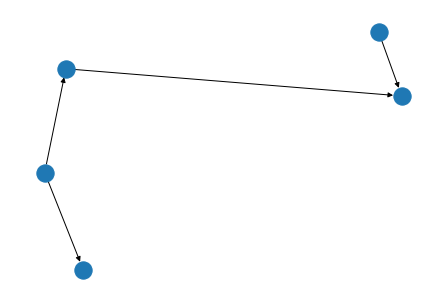

In [3]:
import dgl
import dgl.function as fn # contains all the built-in optimized message passing and reduce functions.
import networkx as nx
%matplotlib inline

def init_g(d_k):
    g = dgl.graph(([0, 0, 2, 3], [1, 2, 4, 4]))
    n = g.number_of_nodes()
    g.ndata['k'] = torch.randn(n, d_k)
    g.ndata['q'] = torch.randn(n, d_k)
    g.ndata['v'] = torch.randn(n, d_k)
    return g

g = init_g(12)

nxg = nx.DiGraph(g.to_networkx())
print(g)
nx.draw(nxg)

## Utils

In [4]:
# plotting utils

def to_nxg(g: dgl.DGLGraph) -> nx.DiGraph:
    nxg = nx.DiGraph(g.to_networkx())
    return nxg
    
def plot_graph(g: dgl.DGLGraph, ax=None, prog='neato', **kwargs):
    nxg = to_nxg(g)
    pos = nx.nx_agraph.pygraphviz_layout(nxg, prog=prog)
    nx.draw(nxg, pos=pos, ax=ax, **kwargs)
    return ax, pos, nxg
    
def attn_to_sparse(g: dgl.DGLGraph, attn: torch.Tensor):
    n = g.number_of_nodes()
    i = torch.stack(g.edges())
    v = attn
    x = torch.sparse_coo_tensor(i, v.flatten(), (n, n))
    return x

def plot_attn(g: dgl.DGLGraph, attn: torch.Tensor, ax=None):
    x = attn_to_sparse(g, attn)
    sns.heatmap(x.to_dense().numpy(), ax=ax)

def plot_graph_and_attn(g: dgl.DGLGraph, attn: torch.Tensor):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    axes[0].set_title("Graph")
    axes[1].set_title("Attention")
    plot_graph(g, ax=axes[0], width=attn.flatten().numpy())
    plot_attn(g, attn, ax=axes[1])

## Attention layer of Graph Transformer

The **attention** layer, each node in module learns to assign weights on its incoming edges. For node pair $(i,j)$ with node $x_i,x_j \in \mathbb{R}^n$, the score of connection is as follows:

$$
q_j = W_q \cdot x_j \\
k_i = W_k \cdot x_i \\
v_i = W_v \cdot x_i \\
\text{score} = q_j k_i^\top
$$

$W_q, W_k, W_v \in \mathbb{R}^{n \times d_k}$ map the representations of x to "query", "key", and "value" space repsectively. These values are three different linear projections of the data. For the "query" case ($W_j$), these are linear projections of source nodes for edges. For "key" and "value", were are linear projections of the destination nodes. The dot product between query source nodes and key destination nodes computes the score of the given connection.

$$
\text{Attention}(Q, K, V) = \text{Softmax}\Bigg(\frac{QK^\top}{\sqrt{d_k}}\Bigg)V
$$


### Attention: Using Torch

<ipython-input-5-56177758f41a>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score = F.softmax(_z / scale)


tensor([[1.0000],
        [1.0000],
        [0.2813],
        [0.7187]])


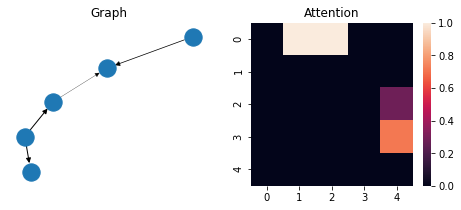

In [5]:
def attention(g):
    attention_arrs = []
    score_arrs = []
    
    q = g.ndata['q']
    d_k = q.size(-1)
    scale = d_k**0.5
    n = g.number_of_nodes()
    for i in range(n):
        idx = torch.where(g.edges()[1] == i)[0]
        src = g.edges()[0][idx]
        dst = g.edges()[1][idx]
        src = torch.tensor(list(set(src.tolist())), dtype=torch.long)
        dst = torch.tensor(list(set(dst.tolist())), dtype=torch.long)

        # dst
        q = g.ndata['q'][dst]

        #src
        k = g.ndata['k'][src]
        v = g.ndata['v'][src]
        _z = torch.matmul(q, k.transpose(-2, -1))
        
        score = F.softmax(_z / scale)
        out = torch.matmul(score, v)
        if out.size(0) == 0:
            out = torch.zeros_like(g.ndata['q'][:1])
        attention_arrs.append(out)
        score_arrs.append(score)

    attention = torch.cat(attention_arrs)
    score = torch.cat([s.T for s in score_arrs if s.size(0)], 0)
    return attention, score

g = init_g(3)
out, attn = attention(g)
print(attn)
plot_graph_and_attn(g, attn)

### Attention: With standard message passing
Now we will walk through the forward propogation using dgl. First, lets create a simple test graph and attach some data to the nodes. Note, however, we cannot appropriately apply edge softmax.

In [6]:
# example: applying basic matmul qk^T in dgl

# initialize graph
g = init_g(3)
print(g.edges())

# lets run attention on edges (2, 4), (3, 4)
i = torch.tensor([0, 1])
src = g.edges()[0][i]
dst = g.edges()[1][i]

# we only look at unique edges
src = torch.tensor(list(set(src.tolist())))
dst = torch.tensor(list(set(dst.tolist())))
print(src, dst)

# filter the data
k = g.ndata['k'][src]
v = g.ndata['v'][src]
q = g.ndata['q'][dst]

# apply matmul in non-graph version
# for mxn, expect a mxm matrix
_z = torch.matmul(q, k.transpose(-2, -1))
print(_z)

# dgl version
with g.local_scope():
    g.apply_edges(fn.v_mul_u('q', 'k', '_z'))
    print('\nEdge Messages: a \'n_edge x d_model\'')
    print(g.edata['_z'])
    print(g.edata['_z'].sum(1))

# typical message passing would take the messages on each edge
# and for every node, sum incoming message. For attention,
# we just want to sum across d_k. We may want to optimize
# this by creating a corresponding kernel to combine this operation.
# We therefore create a new user defined function.
print("\nNote this is different from the typical message passing paradigm, which sums incoming edges.")
with g.local_scope():
    g.update_all(fn.v_mul_u('q', 'k', '_z'), fn.sum('_z', 'score'))
    print(g.ndata['score'])
    
# `v_dot_u` will perform these same operations concisely
print("\nHowever, the most concise was is to use the `v_dot_u` operator, followed by sum as this fuses the kernels")
with g.local_scope():
    g.apply_edges(fn.v_dot_u('q', 'k', '_z'))
    print(g.edata['_z'])

(tensor([0, 0, 2, 3]), tensor([1, 2, 4, 4]))
tensor([0]) tensor([1, 2])
tensor([[ 0.3251],
        [-2.5458]])

Edge Messages: a 'n_edge x d_model'
tensor([[-0.0063,  0.3617, -0.0302],
        [-2.6947,  0.1722, -0.0232],
        [-0.2477,  1.2877, -0.0371],
        [-0.1710, -0.0994,  0.1819]])
tensor([ 0.3251, -2.5458,  1.0029, -0.0885])

Note this is different from the typical message passing paradigm, which sums incoming edges.
tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.0063,  0.3617, -0.0302],
        [-2.6947,  0.1722, -0.0232],
        [ 0.0000,  0.0000,  0.0000],
        [-0.4187,  1.1884,  0.1447]])

However, the most concise was is to use the `v_dot_u` operator, followed by sum as this fuses the kernels
tensor([[ 0.3251],
        [-2.5458],
        [ 1.0029],
        [-0.0885]])


### Attention: Using Generalized Sampled Dense-Dense Matrix Multiplication (GSDDMM)

We can perform this operation using the provided GSDDMM (Generalized Sampled Dense-Dense Matrix Multiplication) operations, which is much more memory efficient that materializing the tensors using standard send and receive. Between the message-passing API and GSpMM/GSDMM, both API are the same efficiency.


Note that the above procedure is very inefficient. Firstly, we create a new tensor for every node, secondly, we are materializing new tensors at every step of the computation, and lastly, we perform a concatenation to obtain the final attention tensor. To optimize this procedure, lets use **dgl**.

<ipython-input-5-56177758f41a>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score = F.softmax(_z / scale)


tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.5976, -0.1718, -0.5715],
        [ 0.5976, -0.1718, -0.5715],
        [ 0.0000,  0.0000,  0.0000],
        [-0.5388, -0.6003,  0.4234]])
tensor([[1.0000],
        [1.0000],
        [0.7921],
        [0.2079]])


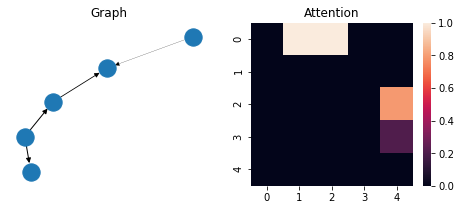

In [7]:
def attention_dgl_gsddmm(g):
    q = g.ndata['q']
    k = g.ndata['k']
    v = g.ndata['v']
    d_k = q.size(-1)
    score = Fops.edge_softmax(g, Fops.v_dot_u(g, q, k) / d_k**0.5)
    out = Fops.u_mul_e_sum(g, v, score)
    return out, score

g = init_g(3)
out0, attn0 = attention(g)
out1, attn1 = attention_dgl_gsddmm(g)

assert torch.allclose(out0, out1)
assert torch.allclose(attn0, attn1)
print(out1)
print(attn1)

plot_graph_and_attn(g, attn0)

**Attention with half-complete graph**

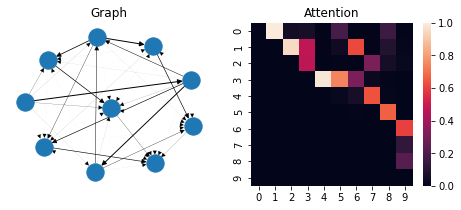

In [8]:
def init_complete_g(n_nodes, d_k, half=False):
    edges = torch.combinations(torch.arange(n_nodes), with_replacement=False).T
    edges = edges[:, :]
    
    g = dgl.graph((edges[0], edges[1]))
    if not half:
        g.add_edges(edges[1], edges[0])
    n = g.number_of_nodes()
    x = torch.randn(3, n, d_k) * 2.
    g.ndata['k'] = x[0]
    g.ndata['q'] = x[1]
    g.ndata['v'] = x[2]
    return g

g = init_complete_g(10, 7, half=True)
out, attn = attention_dgl_gsddmm(g)
plot_graph_and_attn(g, attn)

## Multi-Head Attention layer of Graph Transformer

### Multi-head attention using Torch

<ipython-input-9-16eef9341d3c>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = F.softmax(torch.matmul(q, k.transpose(-2, -1)) * d_k**-0.5)


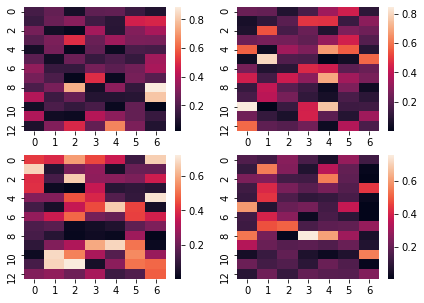

torch.Size([1, 13, 12])


<AxesSubplot:>

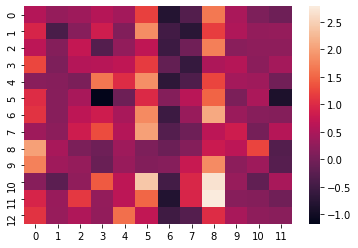

In [9]:
from torch import nn

def torch_multihead_attention(q, k, v, h):
    d_model = k.size(-1)
    d_k = d_model // h
    nbatches = q.size(0)
    assert d_model % h == 0
    assert len(q.shape) == 3
    assert q.size(0) == k.size(0)
    assert q.size(0) == v.size(0)
    assert k.shape == v.shape
    def create_head(x):
        return x.view(nbatches, -1, h, d_k).transpose(1, 2)
    
    q = create_head(q)
    k = create_head(k)
    v = create_head(v)
    
    attn = F.softmax(torch.matmul(q, k.transpose(-2, -1)) * d_k**-0.5)
    out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(nbatches, -1, d_model)
    return out, attn

d_model = 12
q = torch.randn(1, 13, d_model)
k = torch.randn(1, 7, d_model)
v = torch.randn(1, 7, d_model)

out, attn = torch_multihead_attention(q, k, v, 4)
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
for i in range(attn.size(1)):
    ax = axes.flatten()[i]
    sns.heatmap(attn[0, i], ax=ax)
plt.show()

print(out.shape)
sns.heatmap(out[0])

### Multi-head attention: Using DGL/GSDDMM

torch.Size([10, 12])
torch.Size([45, 1])
torch.Size([10, 12])
torch.Size([45, 4, 1])


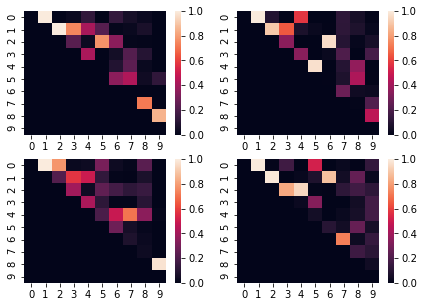

In [10]:
q = torch.randn(10, 12)
k = torch.randn(9, 12)
v = k

g = dgl.graph(([0, 0, 1, 2], [1, 1, 3, 3]))

q = torch.randn(g.number_of_nodes(), 12)
k = torch.randn(g.number_of_nodes(), 12)

def head(x):
    return x.view(x.size(0), -1, 4, 3).transpose(1, 2)

def multihead_attention_dgl_gsddmm(g, h):
    d_model = g.ndata['q'].size(-1)
    def head(x):
        return x.view(x.size(0), -1, h, d_model // h).transpose(1, 2)
    q = head(g.ndata['q'])
    k = head(g.ndata['k'])
    v = head(g.ndata['v'])
    d_k = q.size(-1)
    score = Fops.edge_softmax(g, Fops.v_dot_u(g, q, k) / d_k**0.5)
    out = Fops.u_mul_e_sum(g, v, score)
    out = out.transpose(1, 2).view(g.number_of_nodes(), d_model)
    score = score.view(score.size(0), h, -1)
    return out, score

g = init_complete_g(10, 12, half=True)

out, attn = attention_dgl_gsddmm(g)
print(out.shape)
print(attn.shape)

mh_out, mh_attn = multihead_attention_dgl_gsddmm(g, 4)
print(mh_out.shape)
print(mh_attn.shape)

fig, axes = plt.subplots(2, 2, figsize=(7, 5))
for i in range(mh_attn.size(1)):
    ax = axes.flatten()[i]
    _attn = attn_to_sparse(g, mh_attn[:, i]).to_dense().numpy()
    sns.heatmap(_attn, ax=ax)

## Graph Transformer Modules

We can quickly implement the initial embedding of the MultiHeadAttention. Right now, we are leaving out the more complicated forward propogation. We will walk through that implementation next.

### Multi-Head Graph Attention

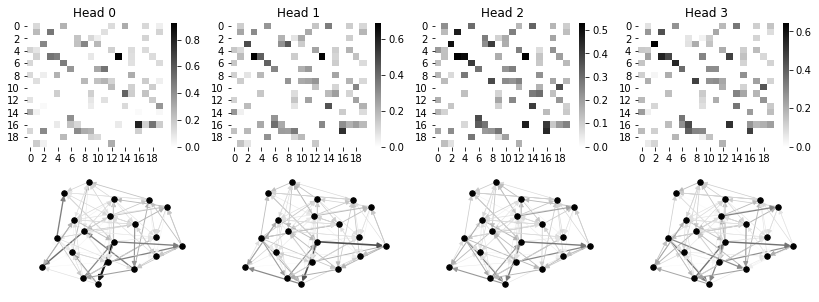

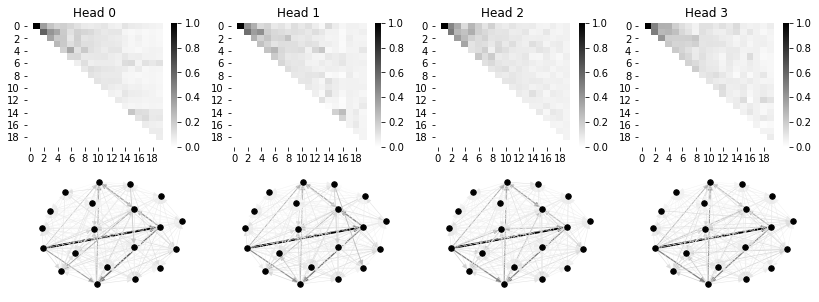

In [11]:
from copy import deepcopy
import matplotlib as mpl
from matplotlib import cm

def clones(net, N):
    return [deepcopy(net) for _ in range(N)]
    
def rand_g(n_nodes, n_edges):
    g = dgl.graph(([], []))
    g.add_nodes(n_nodes)
    edges = torch.randint(0, n_nodes, (2, n_edges))
    g.add_edges(*edges)
    return g

class MultiHeadAttention(nn.Module):
    
    def __init__(self, dim_model, h):
        super().__init__()
        assert dim_model % h == 0
        self.h = h
        self.dim_model = dim_model
        self.d_k = dim_model // h
        self.linears  = clones(nn.Linear(dim_model, dim_model), 4)
        self.attn = None
    
    def _view_head(self, x):
        return x.view(x.size(0), -1, self.h, self.d_k).transpose(1, 2)
        
    def forward(self, g, query, key, value):
        q = self._view_head(self.linears[0](query))
        k = self._view_head(self.linears[1](key))
        v = self._view_head(self.linears[2](value))
        score = Fops.edge_softmax(g, Fops.v_dot_u(g, q, k) / self.d_k**0.5)
        out = Fops.u_mul_e_sum(g, v, score)
        out = out.transpose(1, 2).view(g.number_of_nodes(), self.h * self.d_k)
        score = score.view(score.size(0), self.h, -1)
        self.attn = score
        out = self.linears[3](out)
        return out
    
def plot_multihead_attention(g, attn, cmap='binary', node_color='k', node_size=30, prog='neato', scale_width=2., min_width=0.3):
    fig, axes = plt.subplots(2, 4, figsize=(14, 5))
    for i in range(attn.size(1)):
        ax = axes.flatten()[i]
        ax.set_title("Head {}".format(i))
        a = attn[:, i].detach().flatten()
        _attn = attn_to_sparse(g, a).to_dense().numpy()
        sns.heatmap(_attn, ax=ax, linewidths=0, cmap=cmap)
        norm = mpl.colors.Normalize(vmin=0,vmax=1.)
        edge_colors = cm.get_cmap(cmap)(norm(a))
        edges = g.edges()
        edgelist = [(edges[0][i].item(), edges[1][i].item()) for i in range(g.number_of_edges())]
        
        ax, pos, nxg = plot_graph(g, prog=prog, width=a*scale_width + min_width, edge_color=edge_colors, edgelist=edgelist, ax=axes.flatten()[i+4], node_size=node_size, node_color=node_color)
#         nx.draw_networkx_labels(g, ax=ax, pos=pos, labels={v: v for v in list(range(g.number_of_nodes()))})
        
    
def run_multiheadattn_sanity_check():
    model = MultiHeadAttention(12, 4)

    # sanify check
    g = rand_g(20, 100)
    x = torch.randn(g.number_of_nodes(), 12)
    out = model(g, x, x, x)
    attn = model.attn
    plot_multihead_attention(g, attn, prog='neato')
    plt.show()

    g = init_complete_g(20, 12, half=True)
    x = torch.randn(g.number_of_nodes(), 12)
    out = model(g, x, x, x)
    attn = model.attn
    plot_multihead_attention(g, attn, prog='neato')
    plt.show()
    
run_multiheadattn_sanity_check()

> So why does the half-complete look like a gradient? Attention is relative to all the incoming nodes. If a node only has one incoming edge (as in the upper left corner), the attention is 1.0. Since we defined a half-complete graph, edges represented in the lower-right corner will have more incoming edges. Thus, those will have less average attention given we randomly initialized input data.

### Position-wise Feed Forward

In [12]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.w_2(self.dropout(self.act(self.w_1(x))))
    
def run_ff_sanity_check(x = torch.randn(10, 12)):
    m = PositionwiseFeedForward(12, 24)
    return m(x)
    
run_ff_sanity_check()

tensor([[-5.6503e-02,  1.9645e-01,  5.0553e-01,  1.1200e-01,  6.7056e-02,
         -7.3087e-02, -7.4158e-02,  2.5823e-01, -1.2091e-01, -4.0465e-01,
          1.4309e-03, -1.9251e-01],
        [ 1.4615e-01, -2.2256e-01,  9.7789e-02,  2.5450e-02, -2.4474e-01,
          1.2022e-01, -4.6310e-02,  1.7778e-01, -1.7042e-02, -3.1228e-01,
         -3.1663e-02, -6.2886e-01],
        [-6.1565e-02, -2.4588e-01,  1.5634e-01,  1.5051e-01,  2.5191e-02,
          1.2352e-03, -1.5516e-01,  2.4086e-01, -1.5933e-01, -4.1350e-01,
          3.2764e-01, -4.4407e-01],
        [ 3.9346e-01, -2.1793e-01,  4.1077e-01,  1.1280e-01, -3.9576e-02,
         -2.6110e-01, -6.8140e-02,  2.5326e-01,  1.8849e-01,  3.7623e-02,
          3.0427e-01,  7.1356e-02],
        [ 3.4199e-01,  1.9069e-01,  5.8412e-01,  3.5127e-01,  1.8302e-01,
         -1.6753e-01,  2.8503e-01,  1.0855e-02, -1.1978e-01, -2.2997e-01,
         -3.2964e-01, -3.9962e-01],
        [ 1.5256e-01, -7.9755e-02,  3.8585e-01,  3.0838e-02, -3.5941e-03,
      

### Add and Norm Connection

$$
\text{AddNorm}(x) = \text{LayerNorm} \Big( x + \text{Dropout}\big( \text{Layer}(x) \big) \Big)
$$



In [13]:
from abc import ABC, abstractmethod
from torch import nn
from typing import *
import torch

class SizedModule(ABC) :

    @abstractmethod
    def get_size(self) -> int:
        ...
                  
class AddNorm(nn.Module):
    
    def __init__(self, size: Optional[int] = None, dropout: float = 0.1, layer: Optional[SizedModule] = None):
        super().__init__()
        if size is None and layer is None:
            return ValueError("Either size or layer must be provided")
        self.size = size or layer.get_size()
        self.layer = layer
        self.norm = nn.LayerNorm(self.size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, args=None, kwargs=None, layer: Optional[SizedModule] = None):
        kwargs = kwargs or dict()
        if args is None:
            args = (x,)
        layer = layer or self.layer
        return self.norm(x + self.dropout(layer(*args, **kwargs)))
    

def run_addnorm_sanity_check(x = torch.randn(10, 12)):
    return AddNorm(size=12, layer=nn.Linear(12, 12))(x)

run_addnorm_sanity_check()

tensor([[ 0.4736, -0.0195, -1.6313, -0.5733, -0.0414, -0.0919, -1.6635,  0.1537,
         -0.0362,  0.4660,  0.6529,  2.3107],
        [-0.5149,  0.2590, -1.9933,  1.2705, -1.4068,  0.2615, -0.3666,  1.7232,
         -0.3424, -0.1313,  0.5100,  0.7310],
        [ 2.3027, -0.5716,  0.7925,  0.5752, -0.3840, -0.2960, -1.7093,  0.3474,
         -0.5893,  0.7731, -0.1622, -1.0785],
        [ 0.7725,  0.8970,  0.6609, -1.3492, -0.2478,  0.4054,  1.0820,  0.1447,
         -2.4987,  0.0959,  0.5978, -0.5604],
        [-1.9162,  1.3220,  0.1652,  0.7675, -1.5784, -0.7924,  0.0289,  0.7661,
         -0.4428,  0.1696,  0.0877,  1.4228],
        [-0.9280, -1.4273, -0.6687,  0.3069, -1.1145,  0.8406,  2.0824,  1.1700,
          0.2494, -0.4016,  0.5271, -0.6363],
        [ 0.7727, -1.5165,  1.3235,  0.9942, -0.5318, -0.1290, -0.2424,  1.1709,
          0.0361,  0.2645, -0.0061, -2.1360],
        [ 1.7358, -0.7241,  1.3741, -0.1013, -0.8000,  0.1759,  0.9580, -1.3479,
         -1.0684,  0.5757, -1.

### Embeddings

In [14]:
import math

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)
    
def run_embed_sanity_check():
    lorem = """
    Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor 
    incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis 
    nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. 
    Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore 
    eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, 
    sunt in culpa qui officia deserunt mollit anim id est laborum.
    """.split()

    vocab = set(lorem)
    n_words = len(vocab)
    vocab_idx = torch.arange(n_words)
    embed = Embeddings(12, n_words)
    return embed(vocab_idx)

run_embed_sanity_check().shape

torch.Size([64, 12])

### Encoder

In [15]:
class EncoderLayer(nn.Module):
    
    def __init__(self, size: int, n_heads: int, d_ff: int, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(dim_model=size, h=n_heads)
        self.layers = nn.ModuleList([
            AddNorm(size=size, layer=self.attn, dropout=dropout), 
            AddNorm(size=size, layer=PositionwiseFeedForward(d_model=size, d_ff=d_ff, dropout=dropout))
        ])
        
    def forward(self, g, x):
        x = self.layers[0](x, args=(g, x, x, x))
        x = self.layers[1](x)
        return x
    
class Encoder(nn.Module):
    
    def __init__(self, layer: EncoderLayer, N: int):
        super().__init__()
        self.N = N
        self.layers = nn.ModuleList(clones(layer, N))
        
    def forward(self, g, x):
        for l in self.layers:
            x = l(g, x)
        return x
    
def run_encoder_layer_sanity_check():
    model = EncoderLayer(12, 4, 32)
    g = rand_g(20, 40)
    x = torch.randn(g.number_of_nodes(), 12)
    return model(g, x)

def run_encoder_sanity_check():
    model = Encoder(EncoderLayer(12, 4, 32), 4)
    g = rand_g(20, 40)
    x = torch.randn(g.number_of_nodes(), 12)
    return model(g, x)

run_encoder_layer_sanity_check()
run_encoder_sanity_check().shape

torch.Size([20, 12])

### Decoder

In [16]:
class DecoderLayer(nn.Module):
    
    def __init__(self, size: int, n_heads: int, d_ff: int, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(dim_model=size, h=n_heads)
        self.src_attn = MultiHeadAttention(dim_model=size, h=n_heads)
        self.layers = nn.ModuleList([
            AddNorm(size=size, layer=self.self_attn, dropout=dropout), 
            AddNorm(size=size, layer=self.src_attn, dropout=dropout),
            AddNorm(size=size, layer=PositionwiseFeedForward(d_model=size, d_ff=d_ff, dropout=dropout))
        ])
        
    def forward(self, g, x, m):
        x = self.layers[0](x, args=(g, x, x, x))
        x = self.layers[1](x, args=(g,), kwargs=dict(query=x, key=m, value=m))
        x = self.layers[2](x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, layer: DecoderLayer, N: int):
        super().__init__()
        self.N = N
        self.layers = nn.ModuleList(clones(layer, N))
        
    def forward(self, g, x, m):
        for l in self.layers:
            x = l(g, x, m)
        return x
    
def run_decoder_layer_sanity_check():
    model = DecoderLayer(12, 4, 32)
    g = rand_g(20, 40)
    x = torch.randn(g.number_of_nodes(), 12)
    m = torch.randn(g.number_of_nodes(), 12)
    return model(g, x, m)

def run_decoder_sanity_check():
    model = Decoder(DecoderLayer(12, 4, 32), 4)
    g = rand_g(20, 40)
    x = torch.randn(g.number_of_nodes(), 12)
    m = torch.randn(g.number_of_nodes(), 12)
    return model(g, x, m)

run_decoder_layer_sanity_check()
run_decoder_sanity_check().shape

torch.Size([20, 12])

### Positional Encoding

$$
PE_{(pos,2i)} = \sin \big( pos / 10000^{2i / d_{\text{model}}} \big) \\
PE_{(pos,2i+1)} = \cos \big( pos / 10000^{2i / d_{\text{model}}} \big) 
$$

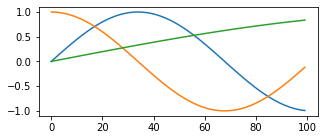

In [17]:
max_len = 500
d_model = 12
pe = torch.zeros(max_len, d_model)
pos = torch.arange(0, max_len).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2) / d_model * -math.log(10000.0))

pe[:, 0::2] = torch.sin(pos * div_term)
pe[:, 1::2] = torch.cos(pos * div_term)

plt.figure(figsize=(5, 2))
plt.plot(pe.numpy()[:100, 4:7]);

In [18]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model, requires_grad=False)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) / d_model * -math.log(10000.0))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        with torch.no_grad():
            pe = self.pe[:, :x.size(1)]
        x = x + pe
        return self.dropout(x)

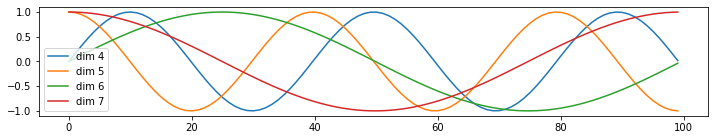

In [19]:
plt.figure(figsize=(12, 2))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

### Generator

In [20]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

### EncoderDecoder

#### Walkthrough

For the language translation task, we will have a set of source language texts and target language texts. Here, we will map tokens within a sentence to node in a graph.The source language sentences can be intepreted as a complete graph, with node_ids corresponding to source vocabulary ids and nodes ordered by the sentence (for positional embedding).

Correspondingly, for the target graph, we will have a half-complete graph. In the original paper, the authors used a mask to prevent the decoder from looking at future tokens (i.e. *cheating*). Here, that is implicit in the graph, provided we construct the graph in the correct way.

> Notice that there is no cross-segment connections here. Each graph is its own entity. This is a topic for further improvement in Transformer literature. The vanilla Transformer has a fixed *attention span**, in that attention only considers the current sentence or segment. No information can flow between fixed length segments. This is known as *context segmentation*. The Transoformer-XL model [Dai et. al. 2019](https://arxiv.org/abs/1901.02860) tries to solve this by reusing hidden states between segments and using a new positional encoding that is suitable for reused states.

The graph structure makes it possible that we can create sparse attention graphs and unique attention architectures. Here, it is fairly straightforward, but the graph NN allows us to go beyond simple masking (as in **Attention is All You Need**) and explore new structures.

> Its possible the positional embeddings are no longer necessary IF we were to add another different type of edge to the graph and propogate that information. I do not test this idea here however. This may have relevance to longer attentions spans seen in Transformer-XL

<Figure size 432x288 with 0 Axes>

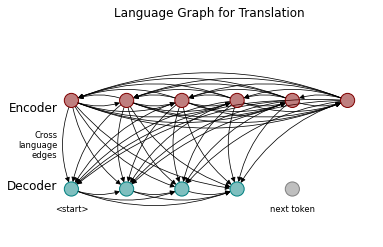

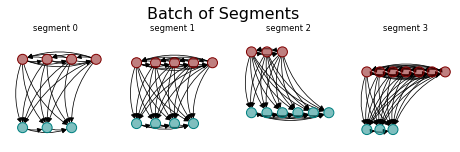

In [307]:
# walkthrough of language graph creation

import networkx as nx
import dgl
import torch
import itertools


def to_tuple(x):
    return tuple(x)

def torch_product(a, b):
    return torch.stack([torch.stack(x) for x in itertools.product(torch.arange(a), torch.arange(b))])

def iter_node_types(g):
    visited = set()
    for x in g.canonical_etypes:
        n1, e, n2 = x
        for n in (n1, n2):
            if n not in visited:
                yield n
                visited.add(n)

def create_fake_language_graph(src_size=7, dst_size=5):
    dst_edges = torch.combinations(torch.arange(dst_size)).T
    src_edges = torch.combinations(torch.arange(src_size), with_replacement=True).T
    src_edges = torch.cat([src_edges, torch.flip(src_edges, dims=(0,))], dim=1)
    g = dgl.heterograph({
        ('src', 'src', 'src'): tuple(src_edges),
        ('dst', 'dst', 'dst'): tuple(dst_edges),
        ('src', 'cross', 'dst'): tuple(torch_product(src_size, dst_size).T)
    })
    return g

def hetrograph_to_nxg(g):
    nxg = nx.DiGraph()
    for y, ntype in enumerate(iter_node_types(g)):
        for n in g.nodes(ntype=ntype):
            node = ntype + '_' + str(n.item())
            data = {'id': n, 'ntype': ntype, 'pos': (n.item(), y)}
            nxg.add_node(node, **data)
    for src, etype, dst in g.canonical_etypes:
        edges = torch.stack(g.edges(etype=etype))
        for n1, n2 in edges.T:
            n1 = src + '_' + str(n1.item())
            n2 = dst + '_' + str(n2.item())
            nxg.add_edge(n1, n2, etype=etype)
    return nxg
    

def add_alpha(rgb, alpha):
    colors = []
    for _rgb in rgb:
        if len(_rgb) == 3:
            _rgb = _rgb + (alpha,)
            colors.append(_rgb)
        elif len(_rgb) == 4:
            _rgb = tuple(list(_rgb)[:-1]) + (alpha,)
            colors.append(_rgb)
        else:
            raise ValueError
    return colors

def draw_nxg_with_pos(G,      
                      connectionstyle="arc3,rad=0.1",
                    width=0.1,
                    node_size=100.,
                    linewidths=1,
                      node_fill_alpha=0.3,
                      ax=None):
    scale = 200.
    pos = {n: (d['pos'][0]*scale, d['pos'][1]*2*scale) for n, d in G.nodes(data=True)}
    node_colors = []
    for n, ndata in G.nodes(data=True):
        if ndata['ntype'] == 'src':
            node_color = (0.5, 0, 0)
        elif ndata['ntype'] == 'dst':
            node_color = (0, 0.5, 0.5)
        else: 
            node_color = (0.5, 0.5, 0.5)
        node_colors.append(node_color)

    # nx.draw_networkx_nodes(G, pos)
    nx.draw(
        G, pos,
        connectionstyle="arc3,rad=0.2",
        width=width,
        node_color=add_alpha(node_colors,node_fill_alpha),
        node_size=node_size,
        linewidths=linewidths,
        edgecolors=node_colors,
        ax=ax
    )
    
# Create fake language graph
g = create_fake_language_graph(6, 4)
nxg = hetrograph_to_nxg(g)

# plot the graph
plt.tight_layout()
fig = plt.figure()
ax = fig.gca()
ax.set_title("Language Graph for Translation")
ax.text(-50, 175*2, 'Encoder', horizontalalignment='right', fontsize='large')
ax.text(-50, 0, 'Decoder', horizontalalignment='right', fontsize='large')
ax.text(-50, 100*2, 'Cross\nlanguage\nedges', horizontalalignment='right', verticalalignment='center', fontsize='small')
nxg.add_node('out', ntype='out', pos=(4, 0))
ax.text(800, -100, 'next token', horizontalalignment='center', fontsize='small')
ax.text(0, -100, '<start>', horizontalalignment='center', fontsize='small')
draw_nxg_with_pos(nxg, node_size=200., node_fill_alpha=0.5, width=0.75, ax=ax)
plt.show();

fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for i, (a, b) in enumerate([(4, 3), (5, 4), (3, 6), (7, 3)]): 
    g = create_fake_language_graph(a, b)
    nxg = hetrograph_to_nxg(g)
    ax=axes.flatten()[i]
    ax.set_title('segment {}'.format(i), fontsize='small')
    draw_nxg_with_pos(nxg, node_size=100., node_fill_alpha=0.5, width=0.75, ax=ax)
fig.suptitle("Batch of Segments", fontsize=16, verticalalignment='bottom');

#### How does training work?

During training, our dataset will likely derive from several translated texts. We will segment the texts (see *context segmentation* problem above for issues associated with this) into *source* and *target* segments, typically at the sentence level. Say for a given sentence pair, we have a source sentence of length $l_{src}$ composed of tokens $s_0 \dots s_{l_{src}}$ and target tokens $t_0 \dots t_{l_{target}}$. To train, we will provide source tokens $s_0 \dots s_{l_{src}}$ and target tokens $t_0 \dots t_{l_{target} - 1}$ (target tokens minus the last token. The goal of the translator will be to predict the last token $t_{l_{target}}$. For the decoder, the first token for all segments is a special `<start>` token.

If you've read the "Attention Is All You Need" paper, this is what is meant in the first figure by the output "shifted by one".

#### How does inference work?

For inference (here, also call the translation task), we will be provided with the source sentence and the goal is to generate the target sentence. To start, we initialize the decode with a special `<start>`. We retrieve a new segment as an output `<start> TOKEN_0`. We feed that output back in to produce `<start> TOKEN_0 TOKEN_1` and we contiue this process (called *autoregressive*) until we get an `<end>` token, designating that the translation is complete.

#### The EncoderDecoder Module

In [20]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, embedding, positional_embedding, encoder, decoder, generator):
        super().__init__()
        self.embedding = embedding
        self.encoder = encoder
        self.decoder = decoder
        self.pos_embed = positional_embedding
        self.generator = generator
        
d_model = 12
h = 4
d_ff = 32
vocab_size = 100
n_encode = 4
n_decode = 4
max_len = 5000
dropout = 0.1
EncoderDecoder(
    encoder=Encoder(EncoderLayer(d_model, h, d_ff, dropout=dropout), n_encode),
    decoder=Decoder(DecoderLayer(d_model, h, d_ff, dropout=dropout), n_decode),
    embedding=Embeddings(d_model, vocab_size),
    positional_embedding=PositionalEncoding(d_model, dropout=dropout, max_len=max_len),
    generator=Generator(d_model, vocab_size)
);

TypeError: Generator() takes no arguments

## Training Improvements

### Noam Opt (Learning Rate Schedule)

### Label Smoothing

# Causal Inference Engine

In [284]:
import itertools

def nx_iter_roots(g: nx.DiGraph) -> Generator[Hashable, None, None]:
    for n in g.nodes():
        if not list(g.predecessors(n)):
            yield n


def nx_iter_leaves(g: nx.DiGraph) -> Generator[Hashable, None, None]:
    for n in g.nodes():
        if not list(g.successors(n)):
            yield n
            
            
def _default_g(g: nx.DiGraph, global_key: str = None):
    for _, data in g.nodes(data=True):
        data["features"] = np.zeros((1,))
        data["target"] = np.zeros((1,))

    for _, _, data in g.edges(data=True):
        data["features"] = np.zeros((1,))
        data["target"] = np.zeros((1,))

#     g.set_global({"features": np.zeros((1,)), "target": np.zeros((1,))}, global_key)
    return g

def boolean_network(data_size):

    data = []
    nxgs = []
    for _ in range(data_size):
        n_size = np.random.randint(2, 20)
        tree = nx.random_tree(n_size)

        # randomize node directions
        g = nx.DiGraph()
        for n1, n2, edata in tree.edges(data=True):
            i = np.random.randint(2)
            if i % 2 == 0:
                g.add_edge(n1, n2)
            else:
                g.add_edge(n2, n1)
        _default_g(g)

        for n in nx_iter_roots(g):
            ndata = g.nodes[n]
            ndata["target"] = np.array([1.0])
            
        # embed the identity of the graph structure into the node itself
        for n, ndata in g.nodes(data=True):
            ndata['identity'] = np.zeros((2, 20))
            ndata['identity'][0][n] = 1.
            for p in g.predecessors(n):
                ndata['identity'][1][p] = 1
            ndata['identity'] = ndata['identity'].flatten()
            
        for _, _, edata in g.edges(data=True):
            edata['true_edge'] = 1
            
        for n in nx.topological_sort(g):
            ndata = g.nodes[n]
            if "target" not in ndata:
                incoming = []
                for p in g.predecessors(n):
                    pdata = g.nodes[p]
                    incoming.append(pdata["target"])
                incoming = np.concatenate(incoming)
                i = incoming.max()
                if i == 1:
                    o = np.array([0.0])
                else:
                    o = np.array([1.0])
                ndata["target"] = o
        for n1, n2 in itertools.combinations(list(g.nodes), 2):
            g.add_edge(n1, n2)
            edata = g.get_edge_data(n1, n2)
            if not edata:
                edata['true_edge'] = 0
            
        data.append(dgl.from_networkx(g, node_attrs=['features', 'target', 'identity'], edge_attrs=['true_edge']))
        nxgs.append(g)
#         input_data.append(GraphData.from_networkx(g, feature_key="features"))
#         output_data.append(GraphData.from_networkx(g, feature_key="target"))

    return data, nxgs
boolean_network(3)[0][0].ndata

{'features': tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=torch.float64), 'target': tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]], dtype=torch.float64), 'identity': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0.

In [257]:
nx.DiGraph().edge

AttributeError: 'DiGraph' object has no attribute 'edge'

In [203]:
g.edges()

(tensor([0, 0, 4, 4, 5]), tensor([3, 1, 0, 2, 1]))

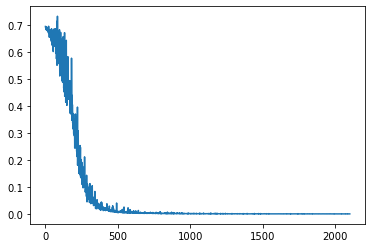

KeyboardInterrupt: 

In [426]:
from tqdm.auto import tqdm
from IPython import display

class Module(nn.Module):
    
    def __init__(self, d_model, h, hidden, dropout):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(d_model, hidden),
            nn.ReLU()
        )
        mod = AddNorm(size=hidden, layer=MultiHeadAttention(hidden, h), dropout=dropout)
        self.layers = nn.ModuleList(clones(mod, 2))
        self.decode = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        x = self.encode(x)
#         for i in range(2):
#             for layer in self.layers[:1]:
#                 x = layer(x, args=(g, x, x, x))
        return self.decode(x)


mod = Module(d_model, 4, 32, 0.2)

data, _ = boolean_network(300)
lossfn = torch.nn.BCELoss()

optim = torch.optim.AdamW(mod.parameters(), lr=1e-3)

losses = []
mod.train()
for epoch in tqdm(range(100)):
    for g in data:
        y = mod(g, g.ndata['identity'].float())
        y_hat = g.ndata['target'].float()
        loss = lossfn(y, y_hat)
        losses.append(loss)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    display.clear_output(wait=True)
    plt.plot(losses)
    plt.show()

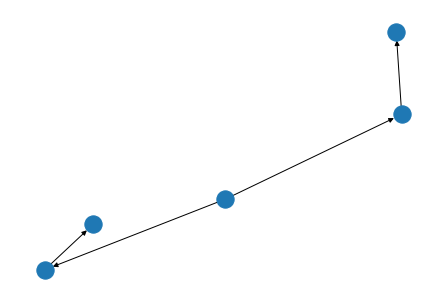

<AxesSubplot:>

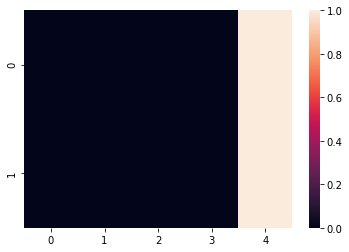

In [435]:
data, _ = boolean_network(1)
g = data[0]
g.ndata['identity'] = g.ndata['identity'].float()

edges = torch.stack(g.edges())[:, g.edata['true_edge'].bool()]

nxg = nx.DiGraph()
nxg.add_edges_from(edges.T.numpy())
nx.draw(nxg)
plt.show()
y = mod(g, g.ndata['identity'])
y_hat = g.ndata['target']

sns.heatmap(torch.stack((y, y_hat)).squeeze(-1).detach().numpy())

### Crosstalk orthogonality matrix

We can evaluate all nodes to discover the orthogonality matrix.

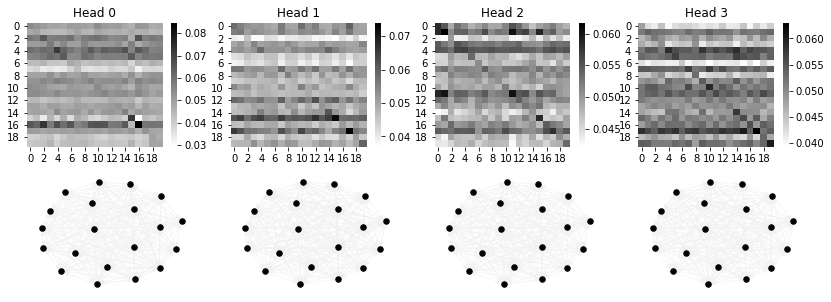

In [411]:
nxg = nx.DiGraph()

for i, j in list(itertools.product(list(range(20)), repeat=2)):
    src = torch.zeros(20)
    dst = torch.zeros(20)
    nxg.add_edge(i, j)
    
    src[i] = 1
    dst[j] = 1
    nxg.add_node(i, identity=torch.cat([src, dst]))
    nxg.add_node(j, identity=torch.cat([dst, src]))
    

g = dgl.from_networkx(nxg, node_attrs=['identity'])
mod.eval()
y = mod(g, g.ndata['identity'])

attn = mod.layers[0].layer.attn
plot_multihead_attention(g, attn, prog='neato')

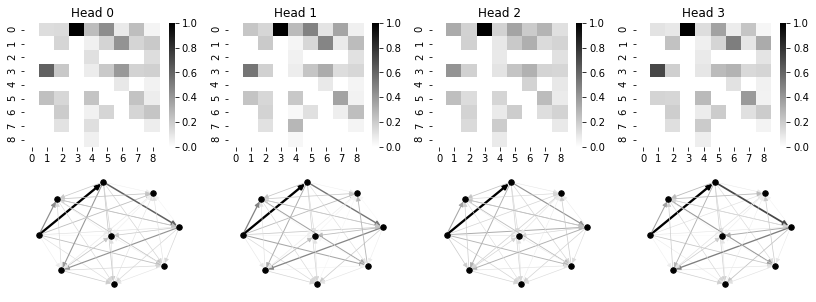

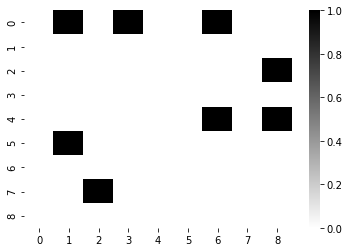

In [412]:
data, _ = boolean_network(1)

g = data[0]
g.ndata['identity'] = g.ndata['identity'].float()

y = mod(g, g.ndata['identity'])

attn = mod.layers[0].layer.attn
plot_multihead_attention(g, attn, prog='neato')
plt.show()

edges = torch.stack(g.edges())[:, g.edata['true_edge'].bool()]

x = torch.zeros(g.number_of_nodes(), g.number_of_nodes())
x[edges[0], edges[1]] = 1
sns.heatmap(x, cmap='binary')
plt.show()

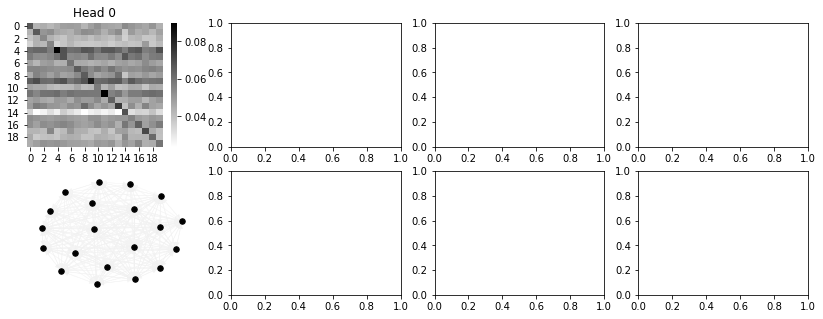

In [386]:
nxg = nx.DiGraph()

for i, j in list(itertools.product(list(range(20)), repeat=2)):
    src = torch.zeros(20)
    dst = torch.zeros(20)
    nxg.add_edge(i, j)
    
    src[i] = 1
    dst[j] = 1
    nxg.add_node(i, identity=torch.cat([src, dst]))
    nxg.add_node(j, identity=torch.cat([dst, src]))
    

g = dgl.from_networkx(nxg, node_attrs=['identity'])

y = mod(g, g.ndata['identity'])

attn = mod.layers[0].layer.attn
plot_multihead_attention(g, attn, prog='neato')

In [378]:
list(itertools.product(list(range(3)), repeat=2))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

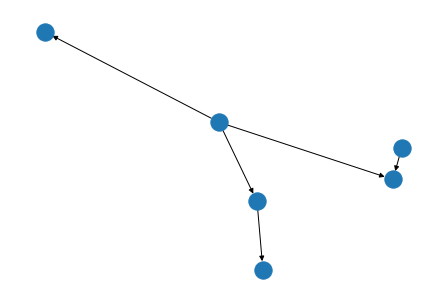

In [333]:
edges = torch.stack(g.edges())[:, g.edata['true_edge'].bool()]

nxg = nx.DiGraph()
nxg.add_edges_from(edges.T.numpy())
nx.draw(nxg)